In [7]:
%pip install pydicom
%pip install nibabel

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/3.3 MB ? eta -:--:--
   ---------------------- ----------------- 1.8/3.3 MB 12.6 MB/s eta 0:00:01
   ---------------------------------------- 3.3/3.3 MB 12.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#import pydicom as dicom
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt

path = "../../Data/Temp/ADNI_136_S_1227_MR_MPR____N3__Scaled_Br_20070810000731580_S26837_I66824.nii"    
img = nib.load(path).get_fdata()
img.shape

(256, 256, 170)

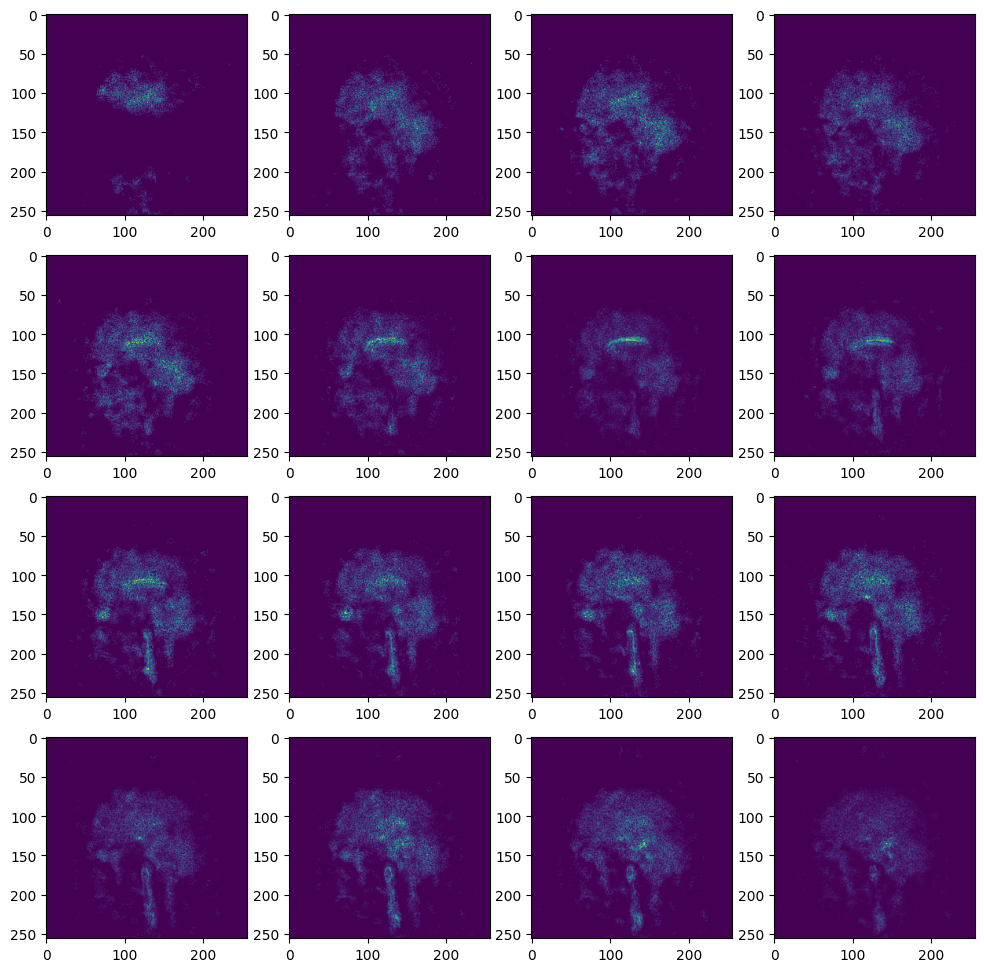

In [ ]:
fig, axes = plt.subplots(4,4, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img[:,:,i])
plt.show()